In [1]:
library(ape)
library(sitePath)

Warning message:
"package 'sitePath' was built under R version 3.6.3"


In [2]:
data(h3n2_align)
data(h3n2_tree)

In [3]:
tree <- addMSA(h3n2_tree, alignment = h3n2_align)

In [4]:
paths <- lineagePath(tree, similarity = 0.023)

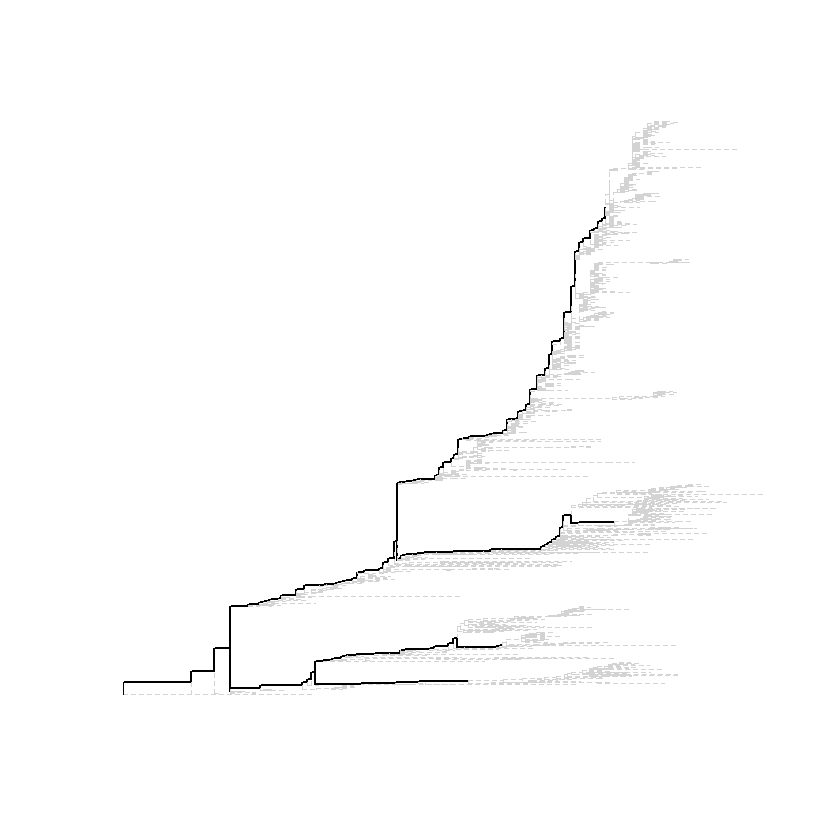

In [5]:
plot(paths)

In [6]:
fixationlineages <- function (paths,
                              minEffectiveSize = NULL,
                              searchDepth = 1,
                              method = c("compare", "insert", "delete"),
                              ...) {
    tree <- attr(paths, "tree")
    nTips <- length(tree[["tip.label"]])
    align <- attr(paths, "align")
    # Generate the site mapping from reference
    reference <- attr(paths, "reference")
    # Decide which miniminzing strategy
    minimizeEntropy <- switch(
        match.arg(method),
        "compare" = sitePath:::minEntropyByComparing,
        "insert" = sitePath:::minEntropyByInserting,
        "delete" = sitePath:::minEntropyByDeleting
    )
    # Get the 'minEffectiveSize' for each fixation
    if (is.null(minEffectiveSize)) {
        minEffectiveSize <- nTips / length(unique(unlist(paths)))
    } else if (!is.numeric(minEffectiveSize)) {
        stop("\"minEffectiveSize\" only accepts numeric")
    }
    minEffectiveSize <- ceiling(minEffectiveSize)
    # Get the 'searchDepth' for heuristic search
    if (searchDepth < 1) {
        stop("\"searchDepth\" should be at least 1")
    } else {
        searchDepth <- ceiling(searchDepth)
    }
    divNodes <- sitePath:::divergentNode(paths)
    nodeAlign <- sitePath:::.tipSeqsAlongPathNodes(
        paths = paths,
        divNodes = divNodes,
        tree = tree,
        align = align
    )
    res <- sitePath:::.findFixationSite(
        paths = paths,
        tree = tree,
        align = align,
        nodeAlign = nodeAlign,
        divNodes = divNodes,
        reference = reference,
        minimizeEntropy = minimizeEntropy,
        minEffectiveSize = minEffectiveSize,
        searchDepth = searchDepth
    )
    attr(res, "paths") <- paths
    attr(res, "reference") <- reference
    class(res) <- "fixationSites"
    return(res)
}

In [7]:
mutations <- fixationlineages(paths, method = "insert")

In [8]:
groupByPath <- lapply(paths, function (p) {
    terminalTips <- sitePath:::.childrenTips(tree, p[length(p)])
    group <- list()
    for (sp in mutations) {
        site <- attr(sp, "site")
        for (mp in sp) {
            tips <- mp[[length(mp)]]
            if (all(terminalTips %in% tips)) {
                toAdd <- lapply(mp, function (tips) {
                    siteChar <- attr(tips, "AA")
                    attributes(tips) <- NULL
                    attr(tips, "site") <- siteChar
                    names(attr(tips, "site")) <- site
                    tips
                })
                group <- c(group, list(toAdd))
            }
        }
    }
    return(group)
})

In [9]:
grouping <- lapply(groupByPath, function (group) {
    res <- group[[1]]
    for (p in group[-1]) {
        for (tips in p) {
            site <- attr(tips, "site")
            # Update grouping for each tips by growing a new list
            newGrouping <- list()
            for (i in seq_along(res)) {
                gp <- res[[i]]
                common <- sort(intersect(tips, gp))
                if (length(common) == 0) {
                    newGrouping <- res[1:i]
                } else if (identical(sort(gp), sort(tips))) {
                    attr(gp, "site") <- c(attr(gp, "site"), site)
                    if (i + 1 <= length(res)) {
                        trailing <- res[(i + 1):length(res)]
                    } else {
                        trailing <- list()
                    }
                    newGrouping <- c(newGrouping, list(gp), trailing)
                    break
                } else {
                    if (identical(sort(gp), common)) {
                        # The new coming tips includes the current group
                        # The extra tips stay for the next loop
                        tips <- setdiff(tips, gp)
                        # Update the SNP site info for the current group
                        attr(gp, "site") <- c(attr(gp, "site"), site)
                        newGrouping <- c(newGrouping, list(gp))
                    } else if (identical(sort(tips), common)) {
                        # The new coming tips are included in the group (they are used up at this point)
                        separate <- setdiff(gp, tips)
                        attributes(separate) <- attributes(gp)
                        attr(tips, "site") <- c(attr(gp, "site"), site)
                        if (i + 1 <= length(res)) {
                            trailing <- res[(i + 1):length(res)]
                        } else {
                            trailing <- list()
                        }
                        newGrouping <- c(newGrouping, list(tips), list(separate), trailing)
                        # Go for the next new coming tips
                        break
                    } else {
                        stop("Something's not right")
                    }
                }
            }
            # The new coming tips are used up and update the grouping
            res <- newGrouping
        }
    }
    return(res)
})

In [130]:
groupingSNP <- lapply(grouping, function (gp) {
#     # Find SNP using first group as reference
#     res <- list()
#     refSites <- attr(gp[[1]], "site")
#     for (tips in gp) {
#         sites <- attr(tips, "site")
#         attr(tips, "site") <- sites[which(vapply(
#             X = seq_along(refSites),
#             FUN = function (i) {
#                 if (refSites[i] != sites[i]) {
#                     return(TRUE)
#                 }
#                 return(FALSE)
#             }, 
#             FUN.VALUE = logical(1)
#         ))]
#         res <- c(res, list(tips))
#     }
    # Prep for growing the tree
    # Define the first node and the first tip cluster
    newParentNode <- length(gp) + 1L # Keep track of the newly added internal nodes
    tipNode <- 1L
    currentTips <- gp[[tipNode]]
    attr(currentTips, "snpSites") <- character()
    tipClusters <- list(currentTips) # The existing tips in the tree
    refSites <- attr(currentTips, "site")
    
    # Define the first edge of the tree
    parentNodes <- newParentNode
    childrenNodes <- tipNode
    edgeSNPs <- list(character())
    # A list to record the fixation sites of the parent nodes
    parentNodesSites <- list()
    parentNodesSites[[as.character(newParentNode)]] <- refSites
    
    # Grow the tree
    for (tipNode in seq_along(gp)[-1]) {
        currentTips <- gp[[tipNode]]
        currentSites <- attr(currentTips, "site")
        # Attach the tip near the most related tips
        # Assume the reference tips are the most related (least number of SNP)
        mostRelatedTipNode <- 1L
        leastSNPnum <- sum(refSites != currentSites)
        # Loop through the rest existing tip clusters
        for (otherTipNode in seq_along(tipClusters)[-1]) {
            otherSites <- attr(tipClusters[[otherTipNode]], "site")
            snpNum <- sum(otherSites != currentSites)
            if (snpNum < leastSNPnum) {
                mostRelatedTipNode <- otherTipNode
                leastSNPnum <- snpNum
            }
        }
        # Find the direct tree edge to the most related tips
        edgeIndex <- which(childrenNodes == mostRelatedTipNode)
        parentNode <- parentNodes[edgeIndex]
        # Tree growing differs according to the SNP against parent node and edge SNP
        parentSites <- parentNodesSites[[as.character(parentNode)]]
        snpSites <- as.character(na.omit(vapply(
            X = names(parentSites),
            FUN = function (site) {
                ref <- parentSites[site]
                snp <- currentSites[site]
                if (ref == snp) {
                    return(NA_character_)
                }
                return(paste0(ref, site, snp))
            },
            FUN.VALUE = character(1)
        )))
        edgeSNP <- edgeSNPs[[edgeIndex]]
        sharedWithEdgeSNP <- intersect(snpSites, edgeSNP)
        # A new internal node is needed when no SNP overlap 
        if (length(sharedWithEdgeSNP) != 0) {
            newParentNode <- newParentNode + 1L
            # Insert the new internal node to the target edge
            parentNodes[edgeIndex] <- newParentNode
            parentNodes <- c(parentNodes, parentNode)
            childrenNodes <- c(childrenNodes, newParentNode)
            edgeSNPs <- c(edgeSNPs, list(sharedWithEdgeSNP))
            # Update the SNP of the directly linked edge to the most related tips
            edgeSNPs[[edgeIndex]] <- setdiff(edgeSNP, sharedWithEdgeSNP)
            # Calculate the site for the new internal node
#             siteToChange <- as.character(regmatches(sharedWithEdgeSNP, regexpr('[0-9]+', sharedWithEdgeSNP)))
            siteToChange <- substr(sharedWithEdgeSNP, 2, nchar(sharedWithEdgeSNP) - 1)
            parentSites[siteToChange] <- substr(sharedWithEdgeSNP, nchar(sharedWithEdgeSNP), nchar(sharedWithEdgeSNP))
            parentNodesSites[[as.character(newParentNode)]] <- parentSites
            # Update the parent node and edge SNP for the current tip node
            parentNode <- newParentNode
            snpSites <- setdiff(snpSites, sharedWithEdgeSNP)
        }
        # Add edge
        parentNodes <- c(parentNodes, parentNode)
        childrenNodes <- c(childrenNodes, tipNode)
        # Add edge SNP
        edgeSNPs <- c(edgeSNPs, list(snpSites))
        # Add the current tips
        tipClusters <- c(tipClusters, list(currentTips))
    }
    res <- list(
        "edge" = cbind(parentNodes, childrenNodes),
        "edge.length" = lengths(edgeSNPs),
        "Nnode" = length(unique(parentNodes)),
        "tip.label" = as.character(seq_along(gp))
    )
    attr(res, "tipClusters") <- tipClusters
    attr(res, "edgeSNPs") <- edgeSNPs
    class(res) <- "phylo"
    return(res)
})

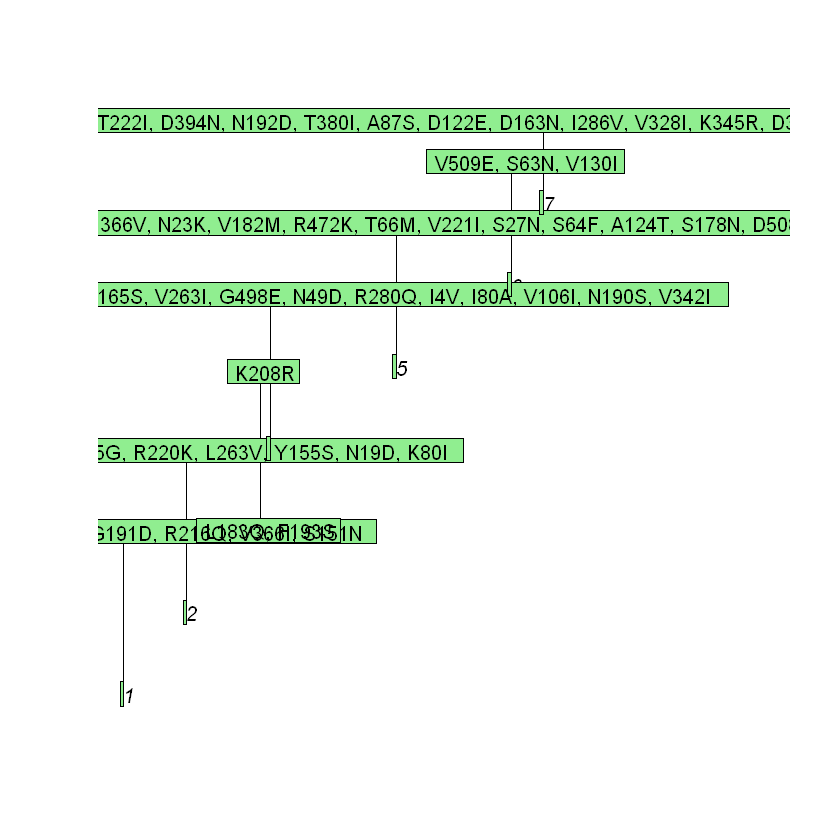

In [145]:
plot.phylo(groupingSNP[[4]])
edgelabels(vapply(attr(groupingSNP[[4]], "edgeSNPs"), paste, collapse = ", ", FUN.VALUE = character(1)))

In [142]:
print()

 [1] ""                                                                                                                                         
 [2] ""                                                                                                                                         
 [3] "S161P, K179T, G191D, R216Q, V366I, S151N"                                                                                                 
 [4] "L183Q, F193S"                                                                                                                             
 [5] "R68K, S165G, R220K, L263V, Y155S, N19D, K80I"                                                                                             
 [6] ""                                                                                                                                         
 [7] "K208R"                                                                                                                      

In [140]:
print(sapply(attr(groupingSNP[[4]], "edgeSNPs"), function (snp) paste(snp, collapse = ", ")))

 [1] ""                                                                                                                                         
 [2] ""                                                                                                                                         
 [3] "S161P, K179T, G191D, R216Q, V366I, S151N"                                                                                                 
 [4] "L183Q, F193S"                                                                                                                             
 [5] "R68K, S165G, R220K, L263V, Y155S, N19D, K80I"                                                                                             
 [6] ""                                                                                                                                         
 [7] "K208R"                                                                                                                      

In [14]:
parentNodes <- c(5L, 5L, 7L, 7L, 6L, 6L)
childrenNodes <- c(7L, 1L, 6L, 2L, 3L, 4L)
testEdge <- cbind(parentNodes, childrenNodes)
testEdgeSNPs <- list("S139N", character(), "S139N", c("T8517C", "T27641C"), character(), "S139N")
testEdgeLength <- lengths(testEdgeSNPs)

In [15]:
testTree <- list("edge" = testEdge, "edge.length" = testEdgeLength, "Nnode" = 3L, "tip.label" = LETTERS[1:4])
class(testTree) <- "phylo"
testTree


Phylogenetic tree with 4 tips and 3 internal nodes.

Tip labels:
[1] "A" "B" "C" "D"

Rooted; includes branch lengths.

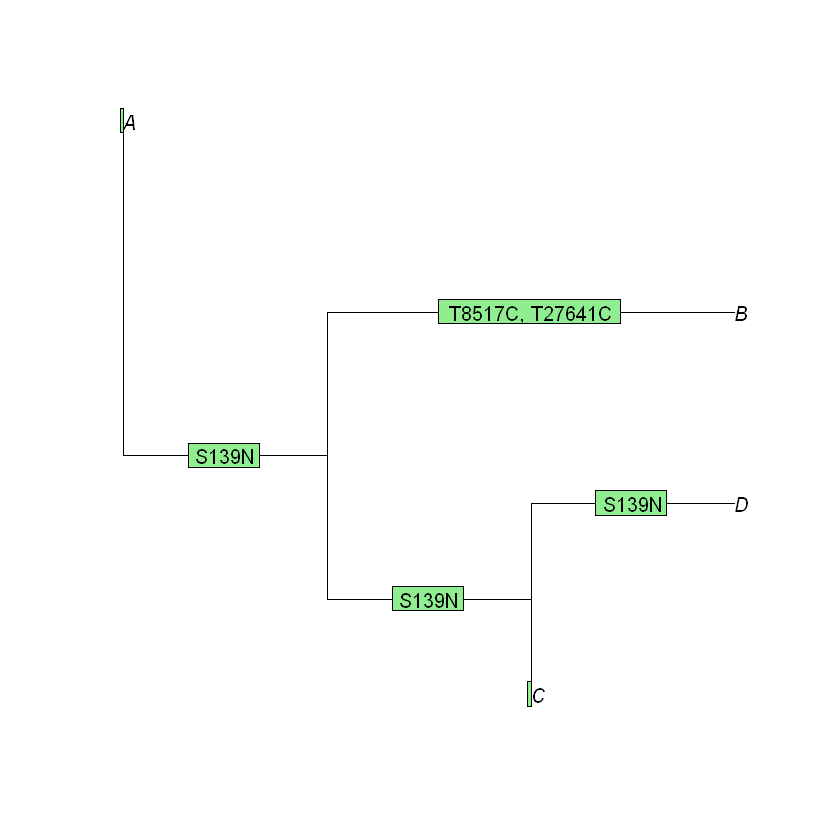

In [17]:
plot(testTree)
ape::edgelabels(sapply(testEdgeSNPs, function (snp) paste(snp, collapse = ", ")))